In [1]:
import os.path
import sys

import numpy as np

from imageio import imread

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

sys.path.append(r'C:\Users\hornu\OneDrive\Documents\repos\flags\scripts\image-scripts')

from histo_utils import calculate_colour_histogram
from image_utils import apply_colour_clustering_to_flag
from cluster_utils import BatchClusterer
from image_utils import ImageEncoder

from image_voronoi import ImageVoronoiCluster, WeightedImageVornoiCluster

from plot_utils import plot_colour_cluster_results, plot_colour_histogram
from plot_utils import plot_flag_clustered_with_clusters, plot_cluster_scores, plot_flag_histo_label_groups

from image_felzen_cleaner import ImageFelzenCleaner
from image_scaler_cleaner import ImageScalerCleaner
from image_voronoi_cleaner import ImageVoronoiCleaner

A number of algorithms are presented which find and correct the spurious colours due to finite resolution of colour images. A conceptully simple method proves to be the most accurate and efficient.


## Motivation

Flags are fascinating. Arrangement of colours and shapes carrying intentional meaning. Comparing them one might uncover messages shared by groups of countries. It is therefore more than tempting apply various classification techniques to sovereign flags accros the world. Then contrast the results with a selected but important attributes of the countries to which they belong. It, however, quickly turns out the graphical representations of flags need a fair amount of preprocessing. This blog post details some of the issues encoutered during analysing images of flags.

## Information loss

Each flag is saved as a `png` file. Png uses a losless compression algorithm as opposed to jpeg, but spurious mixing of colours can still be expected for two reasons
* finite resolution
* the underlying image from which the png was created has smeared colours

By smeared, or satellite colours, we mean colours that are not present in the official specifications of the flags. The colours that are meant to be in the flag are called main colours. In order to illustrate this phenomenon, the flags of Afghanistan, Albania, Domina, Ecuador, Fiji and Mali are plotted along with their colour histograms below.

In [2]:
# TO SKIP -- boring

path_to_images = \
    [  
        r'C:\Users\hornu\OneDrive\Documents\repos\flags\data\clean-data\images\afghanistan.png',
        r'C:\Users\hornu\OneDrive\Documents\repos\flags\data\clean-data\images\albania.png',
        r'C:\Users\hornu\OneDrive\Documents\repos\flags\data\clean-data\images\dominica.png',
        r'C:\Users\hornu\OneDrive\Documents\repos\flags\data\clean-data\images\ecuador.png',
        r'C:\Users\hornu\OneDrive\Documents\repos\flags\data\clean-data\images\fiji.png',
        r'C:\Users\hornu\OneDrive\Documents\repos\flags\data\clean-data\images\mali.png' 
     ]

ref_images = [imread(x) for x in path_to_images]
ref_histos = [calculate_colour_histogram(ImageEncoder.encode(x)) for x in ref_images]
ref_labels = [x.split('\\')[-1][:-4] for x in path_to_images]
ref_groups = tuple((x, y, z,) for x, y, z in zip(ref_images, ref_histos, ref_labels))

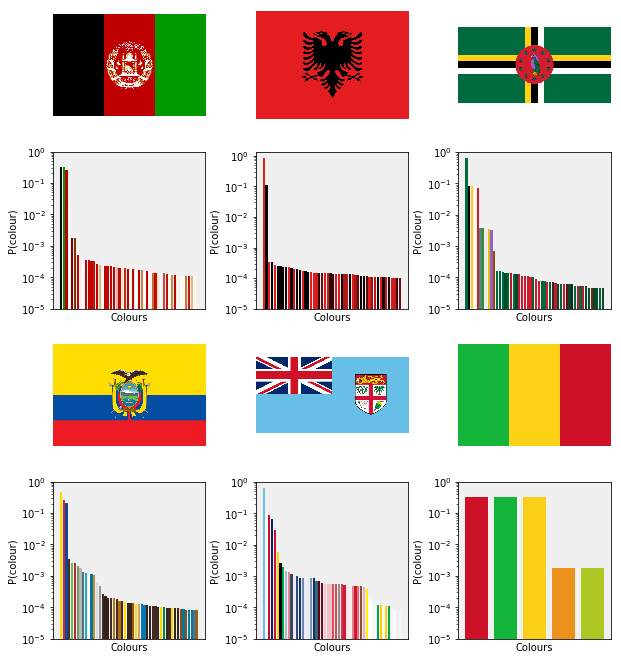

In [3]:
# TO SKIP -- plot setup

plot_flag_histo_label_groups(ref_groups)

In the following we set out handle the satellite colours.

###  What shall we do to the satellite colours and why?

We know that each and every flag is a collection of shapes of well defined colours. We wish to create a fingerprint of colours without the contamination from the colours due to relosution/storage issues. Provided one can separate the real colours from the satellite ones, there are two options:

* **What?** Remove the latter ones, and renormalise the histogram. **Why not?** This method result in distortion of the original fingerprint in addition to blank regions in the image.
* **What?** Assign each satellite colour to a real one. **Why?** Because it undoes the issues by tackling it by its origin.

#### Separation main colours

There is an infinite number of possible routes to take. The most obvious ones are enumerated below.

* **What?** Keep a fixed number of largest colours?
* **Why not?** The number of main colours is not constant (_vide supra_!).
* **What?** Keep colours above a threshold?
* **Why not?** We may loose important colours if their prevalence is low compared to the main colours.
* **What?** Look for jumps in the histogram, and keep colour preceeding the first jump.
* **Why not?** A flag may contain a collection of shapes of different characteristic sizes.
* **What?** Segment the 2D image as opposed to the histogram.
* **Why not?** It is a too obvious solution. (We will do it later on, anyway.)

#### General algorithm

Nevertheless, a generic algorithm can be sketched to define the scopes of the main steps of the cleaning process:


$$
\begin{eqnarray} & & \textbf{Algorithm:} \, \textit{Clean Colours} \\ 
&1.  &\textbf{Input:} \, \mathbf{A}, \text{ RGB image} \\
&2.  & \textbf{Output:} \, \mathbf{A}_{clean}, \text{cleaned RGB image}  \\
&3.  & \texttt{ImageCleaner}(\mathbf{A}) \\ 
% 
&4.  & \quad \mathbf{A}_{clean} \leftarrow \mathbf{0} \qquad \qquad \, \text{(cleaned image)} \\
&5.  & \quad \mathcal{C} \leftarrow \emptyset \qquad \qquad \qquad  \text{(main colours)} \\
&6.  & \quad \mathcal{S} \leftarrow \emptyset \qquad  \qquad \qquad \text{(satellite colours)} \\
%
&7.  & \quad \mathcal{C}, \mathcal{S} \leftarrow \texttt{FindMainColours}(\mathbf{A}) \\
%
&8.  & \quad ColourMap \in \mathcal{S} \times \mathcal{C}  \leftarrow \texttt{CreateColourMap}(\mathcal{C}, \mathcal{S}) \\
%
&9.  & \quad \mathbf{A}_{clean} \leftarrow \texttt{ApplyColourMap}(\mathbf{A}, ColourMap) \\
&10. & \quad \textbf{return} \, \mathbf{A}_{clean} \\
\end{eqnarray}
$$

* $\texttt{FindMainColours}$ separates the main and satellite colours.
* $\texttt{CreateColourMap}$  establishes a replacement map between satellite and main colour
* $\texttt{ApplyColourMap}$ performs the colour replacement on the original image

## Definitions

It is helpful to introduce a small number of terms and notations at this point.

* A non empty set of colours: $\mathcal{X} = \{x_{i}, i: 0 < i \leq N\}\neq \emptyset$. 

* The distance between $x_{i}$ and $x_{j}$ is denoted by $d_{ij}$. We choose this distance so that it fulfills the four properties required to be qualified as a measure.

* Each colour, $x_{i}$ has a weight, $w_{i} \in [0, 1]$. The weight is the colour's propensity in the flag.

* Let us assume there is at least one main colour _i.e._ cluster centre: $x_{} \in \mathcal{C} \cap \mathcal{X} \neq \emptyset$

* $c_{i} \equiv x_{i} \Longleftrightarrow x_{i} \in \mathcal{C}$: a cluster centre.

* $C_{i}$: the $i$-th cluster.

* $\mathcal{S} =\mathcal{X} \setminus \mathcal{C}$: set of satellite nodes 

* $P_{C}(x_{i})$: the probability that a node, $x_{i}$ is a cluster centre.

* $P_{S}(x_{i}) = 1 - P_{C}(X_{i})$: probability of $x_{i}$ being a satellite node is given by, due to the principle of the excluded middle.

* $P(x_{j}| x_{i} \in \mathcal{C}, x_{j} \in \mathcal{S} )$: the probability of $x_{j}$ being the satellite node of $x_{i}$ given the $x_{i}$ is a cluster centre and $x_{j}$ is a satellite node.

* $P(x_{j}| x_{i} \in \mathcal{C}, x_{j} \in \mathcal{S} ) \cdot P_{C}(x_{i}) \cdot P_{S}(x_{j})$ the probability of the _joint_ event that $x_{j}$ being the satellite node of $x_{i}$ and $x_{i}$ is a cluster centre and $x_{j}$ is a satellite node.


## Clustering

### What do we know?

In each flag there are one or more main colours. These are surrounded by satellite colours whose propensity is much smaller compared to the nearest main colours. The satellite colours are likely to be concentrated between main colours (edges where two differently coloured regions meet in the flag).

This definitely calls for a clustering algorithm. Where preferably:
* the number of clusters needs not to be specified
* the propensity of each colour is taken into account

### `sklearn` repertoire

The closest we can get in sklearn are:

* `GaussianMixture` : number of clusters is fixed | there are weights
* `BayesianGaussianMixture` : number of clusters is oprimised | there are no weights. It also uses the rich gets richer principle, that is in line with our problem.
* `DBSCAN` : number of clusters is optimised | there are no weights. It has the concept of cluster cores, which is again strongly alludes to the structure of our problem.
* `affinity_propagation` : number of clusters is optimised | has weights. The weights can be specified as the `preference` parameter, which tells the algorithm which samples are likely to be exemplars _i.e._ the core points in a cluster. This perfectly aligns with our requirements. However, it is really slow and requires considerable amount of tuning.

### Custom clustering algorithm

We proceed to write our own clustering algorithm from which we expect the following:
* colours of large propensities will become cluster centres
* the colours surrounding the cluster centres will be connected to them
* cluster centres will not be connected
* satellite colours will not be connected

There are two views of this problem:
* A graph partitioning (or clustering) problem. The colours span a graph that we wish to partition into directed disjoint graphs. Each disjoint graph has a main node and every edge of the graph is an incoming one with respect to the main node. An edge represents a main colour--satellite colour relationship.
* Distribution optimisation problem (expectation--maximisation). Each main colour is a centre of a distribution. The points sampled from this distribution correspond to the collection of the main and its satellite colours.

We choose to follow the logic of the distribution optimisation problem.

#### Goodness of clustering

The goodness of a particular clustering $\mathcal{C}$ may be expressed by the following quantity:

$$
    s(\mathcal{C}) = \sum\limits_{i = 1}^{N_{c}} \sum\limits_{x_{j} \in C_{i}} \| x_{j} - c_{i} \|_{2}^{2}
$$

This does not, however take into account the weight of the colours, $x_{j}$. The amended formula:

$$
    s(\mathcal{C}) = \sum\limits_{i = 1}^{N_{c}} \sum\limits_{x_{j} \in C_{i}} \| x_{j} - c_{i} \|_{2}^{2}w_{j} \, ,
$$
where $w_{j}$ is the weight of the $j$-th point, penalises clusters where points which are not the centre have large weight. In the following we propose a handful of possible clustering algorithms which minimise the score or its suitably defined derivative.


### Clustering algorithms


#### Voronoi partitioning

One has to decide how to choose the initial cluster centres, and how to minimise the sum above. It is known that there are only a few cluster centres relative to the total number of colours. Therefore one can queue the cluster centres from a list where the colours are enumerated in ascending order with respect to their weights. The centres remain unchanged during the assignment. It is worth noting that the weight $w_{j}$ does not have influence on as to which centre its colours is assigned to. Therefore a simple one pass Voronoi partitioning can return the optimal clustering.

$$
    x_{j} \in C_{i} \Longleftrightarrow \underset{C_{k} \in C}{\operatorname{argmin}} \| C_{k} - x_{j} \|_{2}^{2} = C_{i} 
$$

The number of clusters has to be specified before the algorithm starts. There are two obvious ways to do it:
* set the number of clusters, $N_{c}$ to a fixed number
$$
P_{C}(x_{i}) = 
    \begin{cases}
    1, \quad \text{if} \,\, i \leq N_{c} \\
    0, \quad \text{if} \,\, i > N_{c}
    \end{cases}
$$
* define a threshold, $0 <\eta < 1$ on the propensity above which each colour is considered a cluster centre. 
$$
P_{C}(x_{i}) = 
    \begin{cases}
    1, \quad \text{if} \,\, \eta \leq w_{i} \\
    0, \quad \text{if} \,\, \eta > w_{i}
    \end{cases}
$$
A possible drawback of this method when $\eta$ is too low satellite colours are likely to be considered be main colours. Both methods have its merits and shortcomings. A common negative property is
* The optimal number of clusters can only be decided upon comparing a set of results initiated with different number of cluster centres.

##### Algorithm

The Voronoi clustering algorithm consists of two main subalgorithms, both of which will be reused later on.
* $\texttt{FindMainColours}$: finds the most prevalent colours in an image which are to be the main colours. The complementary set is that of the satellite colours
* $\texttt{CreateColourMap}$: assigns each satellite colour to the nearest main colour thus creating a mapping.

$$
\begin{eqnarray} 
& & \textbf{Algorithm:} \, \textit{Find main colours} \\ 
%
&1. & \textbf{Input:} \, \mathbf{A}: \, \text{image}, \, N_{C}: \, \text{number of main colours}  \\
%
&2. & \textbf{Output:} \, \mathcal{C}, \mathcal{S}: \, \, \text{main and satellite colours} \\
%
&3. & \texttt{FindMainColours}(\mathcal{C}, \mathcal{S}) \\
%
&4. & \quad \mathcal{C} \leftarrow \emptyset \\
%
&5. &  \quad \mathcal{V}, \mathbf{W} \leftarrow \texttt{CountColours}(\mathbf{A})  \qquad \text{(colours and counts in image)} \\
%
&6. &  \quad \mathbf{V} \leftarrow \texttt{SortColours}(\mathcal{V}, \mathbf{W})  \qquad  
\text{(sort colours in ascending order by their weights)}  \\
&7. & \quad \textbf{for} \, i = 1, N_{C} \, \textbf{do} \\
&8. & \qquad \mathcal{C} \leftarrow \mathcal{C} \cap v_{i} \\
%
&9. & \quad \mathcal{S} \leftarrow \mathcal{V} \setminus \mathcal{C} \\
%
&10. & \quad \textbf{return} \, \mathcal{C}, \mathcal{S}
\end{eqnarray}
$$

Each satellite colour is replaced by the nearest main colour in the algorithm $\texttt{CreateColourMap$:

$$
\begin{eqnarray} 
& & \textbf{Algorithm:} \, \textit{Create Colour Map} \\ 
%
&1. & \textbf{Input:} \, \mathcal{C}, \mathcal{S}: \, \, \text{main and satellite colours} \\
%
&2. & \textbf{Output:} \, ColourMap \in \mathcal{S} \times \mathcal{C}: \,\, \text{satellite to main colour replacement map} \\
%
&3. & \texttt{CreateColourMap}(\mathcal{C}, \mathcal{S}) \\
%
&4. & \qquad \quad ColourMap \leftarrow \emptyset \\
%
&5. & \qquad \textbf{for} \, s \in \mathcal{S} \, \textbf{do} \\
&6. & \qquad \quad d_{min} = + \infty \\
&7. & \qquad \quad \textbf{for} \, c \in \mathcal{S} \, \textbf{do} \\
%
&8. & \qquad \qquad d \leftarrow \texttt{Distance}(c, s) \\
&9. & \qquad \qquad \textbf{if} \, d < d_{min} \\
&10. & \qquad \qquad \quad c_{closest} \leftarrow c \\
&11. & \qquad \quad ColourMap \leftarrow ColourMap \cap \{(s, c_{closest})\} \\
%
&12. & \quad \textbf{return} \, ColourMap
\end{eqnarray}
$$


##### Implementation

We therefore choose to set the number of clusters explicitly. The goodness of the clustering is quantified by the weighted formula from above. One thus needs an external mesaure which defined the *best* partition. It is obvious that a clustering consisting of singleton clusters yields the smallest score. One can also penalise explicitly the presence singleton clusters, but that would not be applicable in general scheme.

The Voronoi clustering algorithm is implemented in the `ImageVoronoiCluster` class in the `image-scripts/image_voronoi` module.

##### Preliminary testing 

Let us cluster the flags of Afghanistan and Fiji to gain some information on the merits of the Voronoi clustering (or lack thereof). 
* The Afhgan scree plot looks as expected. There is an elbow in at $N_{C} = 4$. 
* The Fijian results are harder to assess. There is again an elbow at $N_{C} = 4$, but we do know that the flag consists of more main colours. The problem is that the higher order clusters contain much fewer point than the first feew ones, thus the improvement of the score function will be small.

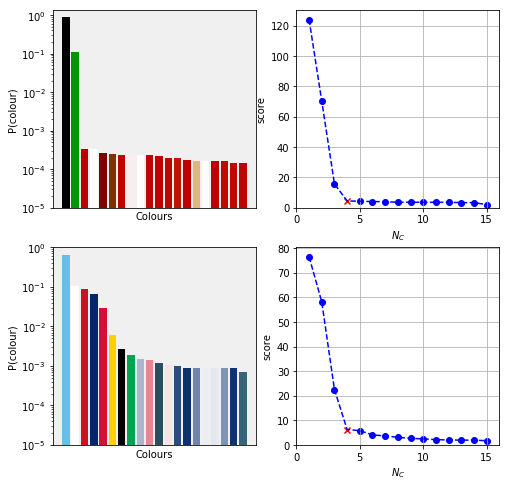

In [4]:
# TO SKIP -- plot setup

encoded = ImageEncoder.encode(ref_images[0])
bcl = BatchClusterer(ImageVoronoiCluster, max_clusters = 15)
bcr = bcl.process(encoded)

fig, axes = plt.subplots(2,2)
fig.set_size_inches(8, 8)
plot_colour_histogram(ref_histos[0].colours, ref_histos[1].counts, axes[0,0], n_show = 20)
plot_cluster_scores(bcr.n_clusters, bcr.scores, bcr.elbow_position, axes[0,1])

encoded = ImageEncoder.encode(ref_images[4])
bcl = BatchClusterer(ImageVoronoiCluster, max_clusters = 15)
bcr = bcl.process(encoded)

plot_colour_histogram(ref_histos[4].colours, ref_histos[4].counts, axes[1,0], n_show = 20)
plot_cluster_scores(bcr.n_clusters, bcr.scores, bcr.elbow_position, axes[1,1])

plt.show()

The main remaining issue is to automate finding the elbow point. There are numerous heuristics to do it from which we will choose that maximises the distance between the line connecting the first and last points of the scree plot and the medial points of the scree plot. It is implemented as `find_elbow_by_distance` in module `image_scripts/cluster_utils`.

One can try to decorate the score curve with various information theoretical scores, such as Bayesian Information Criterion, however it is not granted it would lead to higher accuracy as to deciding the number of optimal clusters.

##### Testing

The six flags from above are cleaned and plotted below. The Voronoi cleaner does a good job when there are only a few colours, as in the case in Afghanistan, Albania, Mali. The main colours with low weights are not likely to be recognised as main colours, the examples of Dominica, Ecuador and Fiji illustrate it. (Find the green bird!)

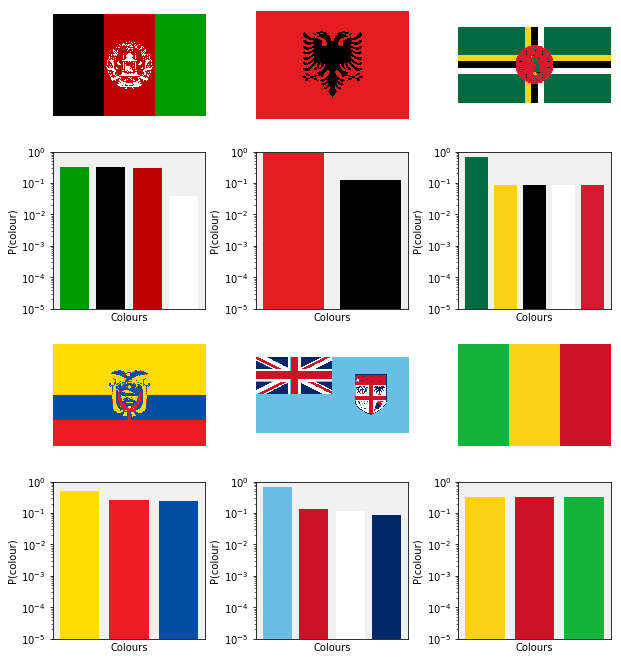

In [5]:
groups = []
for image in ref_images:
    clnr = ImageVoronoiCleaner()
    cleaned = clnr.clean(image)
    groups.append((cleaned, clnr.histo, ""))
    
plot_flag_histo_label_groups(groups)

##### Summary

There is main one issue with the partitioning algorithm:
* The algorithm itself cannot distinguish between main and satellite colours of similar weights
There are three issues with the score function:
* The score function is flawed, for it does not have a property which is characteristic when the number of clusters is equal to the number of main colours (even when the main colours matched).
* As a consequence, the elbow point may not return the optimal number of clusters.
* Finding the elbow -- or defining what it is -- is an art in itself. 

#### K-medoids algorithm

Enumerating the colours in descending order has a possible pitfall. It could happen that satellite colour has larger weight than a main colour due to the topology of the flag. A prime example is the the Dominican flag. Here we face the problem that a satellite colour (mixture of green and black) has larger weight than a main color (purple on the crest of the bird). The succession of partitioning steps are plotted below. The colour purple is not even in the first nine most common colours. Thus is it assigned to the closest main one which is green in this case. However, the best clustering is reached at $N_{C} = 4$ clusters.

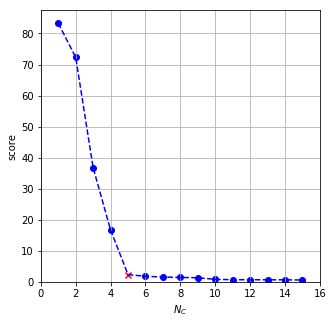

In [6]:
# TO SKIP -- boring

f1 = r'C:\Users\hornu\OneDrive\Documents\repos\flags\data\clean-data\images\dominica.png'
image = imread(f1)
encoded = ImageEncoder.encode(image)
bcl = BatchClusterer(ImageVoronoiCluster, max_clusters = 15)
bcr = bcl.process(encoded)

fig, ax = plt.subplots(1,1)
fig.set_size_inches(5, 5)
plot_cluster_scores(bcr.n_clusters, bcr.scores, bcr.elbow_position, ax)
plt.show()

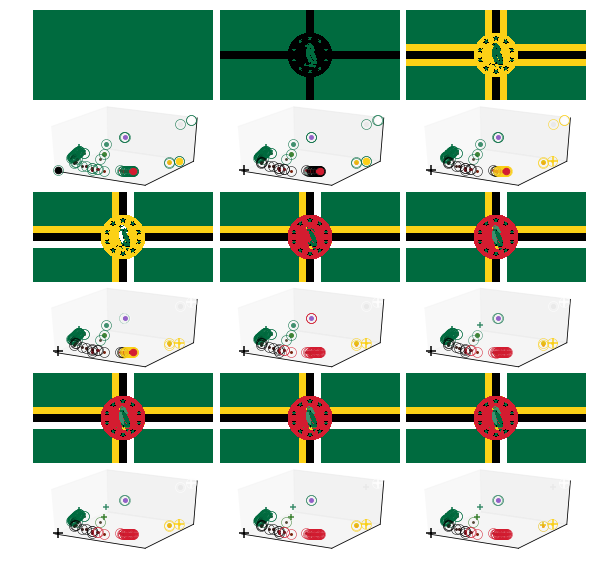

In [7]:
# TO SKIP -- plot setup

plot_flag_clustered_with_clusters(encoded, bcr)

The K-medoids algorithm can possibly overcome this problem by identifying core colours as cluster centres. However, it is likely to move the cluster centres from the colour of the largest weight in the cluster if there are many colours close to the centre. This in fact happens, thus k-medoids is omitted from this discussion.

#### Antechamber

The number of optimal clusters has to be decided case by case when using Voronoi partitioning. A external method has to be invoked that compares the scores as a function of the number of clusters _e.g._ elbow-plot, maximum gap _etc_. We would like to use a clustering algorithm whose score inherently indicates the best cluster assigment _i.e_ it has an extremum at the best $N_{C}$. 

We can introduce the score function:

$$
    s(\mathcal{C}) = \frac{1}{N_{C}}\sum\limits_{i = 1}^{N_{C}} (1 - w_{i}) \sum\limits_{x_{j} \in C_{i}} \| c_{i} - x_{j} \|_{2}^{2} w_{j} 
$$

The the first term of sums penalises assignments where the cluster colours have low weight. This score function may also have the fortunate property of being U-shaped, so that it can be used to measure the goodness of the clustering directly.

##### Implementation

A simple Voronoi partitioning of the distances does not minimise the score. It is an NP-hard problem. We **do not proceed** to looking up or writing an algorithm that minimises the score function. For the very reason it is a flawed score function. For instance, consider the scenario where there are three collinear points with weights 0.9, 0.01, 0.09. The respective distances are 10 and 0.99 ($1 - \epsilon$). The point in the middle is then assigned to the first point. Although, it is more natural to consider it to be a satellite point around the "rightmost" point.

An imperfect imitation would be to invoke a Voronoi partitioning and weigh then multiply each sum of distances by the weight. We **do proceed** to implement this algorithm to test whether it is a good path to follow. This implementation is called `WeightedImageVornoiCluster` in the `image-scripts\image_voronoi_cluster` module.

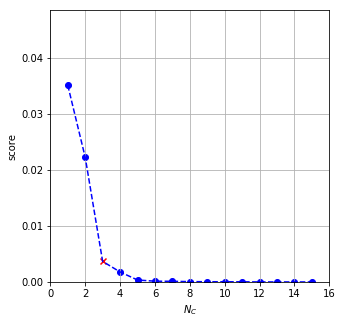

In [8]:
# TO HIDE -- plot setup

f1 = r'C:\Users\hornu\OneDrive\Documents\repos\flags\data\clean-data\images\dominica.png'
image = imread(f1)
encoded = ImageEncoder.encode(image)
bcl = BatchClusterer(WeightedImageVornoiCluster, max_clusters = 15)
bcr = bcl.process(encoded)

fig, ax = plt.subplots(1,1)
fig.set_size_inches(5, 5)
plot_cluster_scores(bcr.n_clusters, bcr.scores, bcr.elbow_position, ax)
plt.show()

##### Analysis

It did not really work, did it?  In fact, it has made matters slightly worse. (And let us just ignore the observation, that singleton clusters still minimise this expression, the time being.) But this exactly what prompts us to think about what we are doing. Let us write out the score function again:
$$
    s(\mathcal{C}) = \frac{1}{N_{C}}\sum\limits_{i = 1}^{N_{C}} (1 - w_{i}) \sum\limits_{x_{j} \in C_{i}} \| c_{i} - x_{j} \|_{2}^{2} w_{j} 
$$

It is a product of three terms. We wish to maximise the first one and minimise the second and third ones. What do these terms mean? 

* The first one represents the probability of $x_{i}$-s not being cluster centres. As the number of centres increase this function increases which simply mirrors the assumption that a cluster centre is likely to have a large weight.
* The third term represents the probability that $x_{j}$ is not a cluster centre.
* The term in the middle is linked to the probability that $x_{j}$ **does not** belong to $x_{i}$ given $x_{i}$ is a cluster centre and $x_{j}$ is not. In summary (and with broad strokes):

$$
\begin{eqnarray}
    1 - w_{i} &\propto & P_{S}( x_{i}) \\
    w_{j} & \propto & P_{S}(x_{j}) \\
    \| c_{i} - x_{j} \|_{2}^{2}  & \propto & P(\neg x_{j} \in C_{i} | x_{i} \in C, x_{j} \in S)
\end{eqnarray}
$$

Thus the score function can symbolically can be represented as:
$$
s(\mathcal{C}) \propto P_{S}( x_{i})\cdot P( \neg x_{j} \in C_{i} | x_{i} \in C, x_{j} \in S)  \cdot P_{S}(x_{j})
$$

This is an asymmetric expression. Negating the first and second terms, we arrive at a more straightforward score function: 
$$
s(\mathcal{C}) \propto P(x_{j} \in C_{i} | x_{i} \in C, x_{j} \in S)  \cdot P_{S}(x_{j}) \cdot  P_{C}(x_{i}) \, ,
$$

which is just a beautiful Bayesian probability function. It is clear now, we have to find the set of cluster centres that maximises the sum:

$$
    f(X,C) = \sum\limits_{i = 1} ^{N_{c}} \sum\limits_{x_{j} \in C_{i}} P(x_{j}| x_{i} \in C, x_{j} \in P_{S}  ) \cdot P_{S}(x_{j}) \cdot P_{C}(x_{i}) \, .
$$

### Bayesian clustering algorithm

We are facing a Bayesian expectation--maximisation problem as we noted before. With the following steps.

* assign probabilites to each node which describe how likely they are cluster centres: $P_{C}(x_{i})$
* Repeat until converged
    * link prospective satellite nodes to each cluster centre: $P(x_{j}| x_{i} \in C, x_{j} \in P_{S})$
    * calculate $f(X,C)$
    * update the probabilities of the cluster centres ($P_{C}(x_{i})$) based on the new information 
    
#### Implementation

It is really tempting to implement or source a Bayesian clsutering algorithm. However, it quickly turns out the time cost associated with it strongly questions, if it is worth doing it. We have to bear in mind the task is not to cluster the colour, but to clean the flag of satellite colours. We therefore proceed to investigate and other prospective method.

## Image segmentation

In the previous paragraphs we tried to cluster the colours based on their histogram. The spatial information which is present in a flag has been completely discarded. Segmentation of the 2D image relies on the distance of adjacent pixels in the colour space. Therefore smaller features of the same colour which were hidden in the tails of the histogram have more chance to be identified. 

### Algorithm

Image segmentation identifies continous regions of the image. It merges satellite colours into the main ones with some probability. Once the segments are known, each colour in that segment is replaced by the most common colour in that segment. 

* $\texttt{FelzenszwalbSegment}$ produces a 2D mask of segments, where each segment is encoded by an integer
* $\texttt{FindMostCommonColour}$ finds the most common colour in a segment.
* $\circ$ operation denotes selection of a segment, 2D slice, from the image

We will use the Felzenszwalb algorithm, for it does not create compact segments. 

$$
\begin{eqnarray} & & \textbf{Algorithm:} \, \textit{Clean Colours} \\ 
&1. &\textbf{Input:} \, \mathbf{X}, \text{ RGB image} \\
&2. & \textbf{Output:} \, \mathbf{X}_{clean}, \text{cleaned RGB image}  \\
&3. & \texttt{FelzenColourAssign}(\mathbf{X}) \\ 
&5. & \quad \mathbf{X}_{clean} \leftarrow \mathbf{0} \\
&6. & \quad \mathbf{M} \leftarrow \texttt{FelzenszwalbSegment}(\mathbf{X}) \\
%
&7. & \quad \textbf{for} \,  i = 1, |M| \, \textbf{do} \\
&8. & \quad \quad color \leftarrow \texttt{FindMostCommonColour}(\mathbf{X} \circ m_{i}) \\
&9. & \quad \quad \mathbf{X}_{clean} \circ m_{i} \leftarrow color \\
&10. & \quad \textbf{return} \, \mathbf{X}_{clean}
\end{eqnarray}
$$

### Testing

The algorithm is implemented in the `ImageFelzenCleaner` class. It is tested on small set of flags. The flags of Albania, Afghanistan, Dominica, Ecuador, Fiji and Mali are chosen for they have features that have proved to be problematic previously. The cleaned flags alogn with their histograms are plotted below.

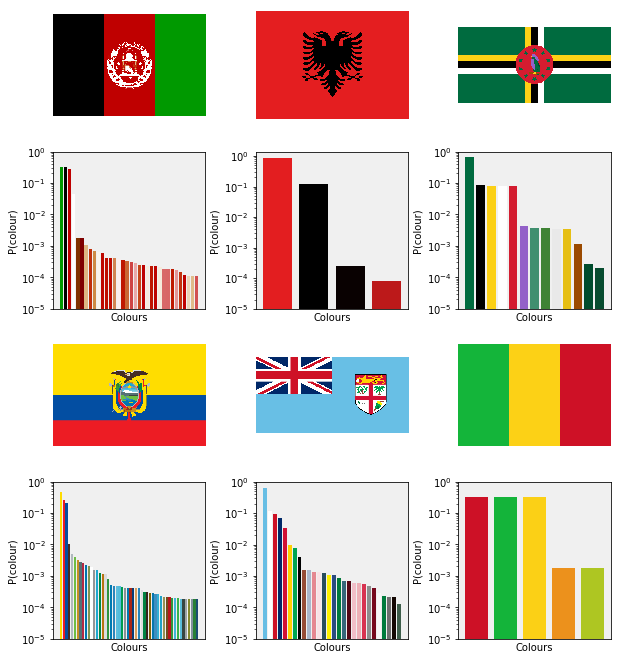

In [9]:
# TO SKIP -- plot setup

groups = []
for image in ref_images:
    clnr = ImageFelzenCleaner(min_size = 'auto')
    cleaned = clnr.clean(image)
    groups.append((cleaned, clnr.histo, ""))
    
plot_flag_histo_label_groups(groups)

### Analysis

The number of satellite colours, in general, have been reduced. It is alos the most joyful that the bird now sports its purple crest and beak in the flag of Dominica. 

There are still numerous smaller segments indentified due to continous patches of satellite colours. This effect is confirmed by inspecting the associated histogram.

This is, however, an easy issue to mitigate. `Felzenszwalb` has an input parameter `min_size` which is the lowest number pixels that are allowed to constitute a segment. 

### Thresholded segmentation

What this threshold should be? The largest theoretically possible segment due to satellite colours is the diagonal of the image. This happens when the flag is composed of an upper and a lower triangles which meet in the diagonal (approximate example Seychelles). The length of this segment, $l_{d}$ can be taken is the threshold. The following decision function is then applied inside the algorithm to decide whether $m_{i}$ is a segment:

$$
\begin{eqnarray}
l_{d} &=& \sqrt{h^{2}_{image} + v^{2}_{image}} \\
%
P(m_{i} \text{ is segment}) & =&
%
\begin{cases}
0\, \, \text{if}\,\, Area(m_{i}) \leq l_{d} \\
1\, \, \text{if}\,\, Area(m_{i}) > l_{d}
\end{cases}
\end{eqnarray}
$$

For the segmentation looks for continous areas of closely similar colours, it does not matter if a satellite colour has an overall weight which is larger than the threshold (_e.g._ United States of America). As long as no smeared colour has a patch larger than the threshold, they will all be merged in to a main colour. This algorithm can be found in the `image-scripts/image_felzen_cleaner` module as `ImageFelzenCleaner`.

The results from the thresholded segmentation/cleaning are displayed below.

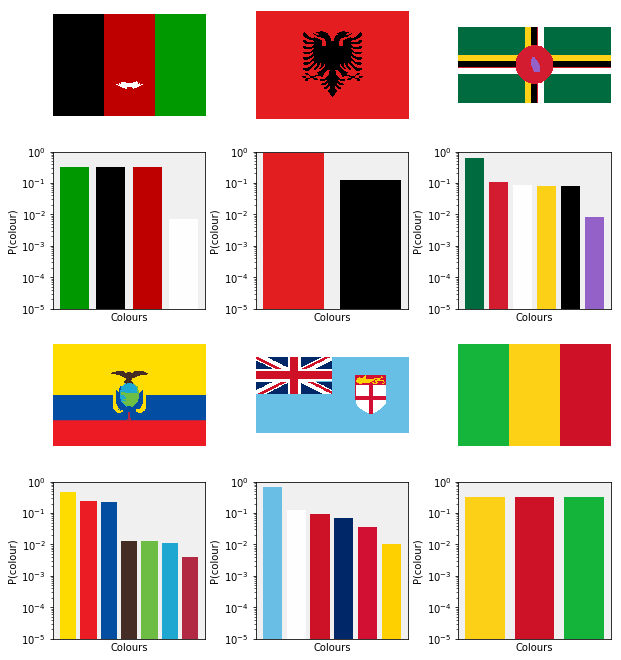

In [10]:
# TO SKIP -- plot setup

groups = []
for image in ref_images:
    clnr = ImageFelzenCleaner(min_size = 'diag')
    cleaned = clnr.clean(image)
    groups.append((cleaned, clnr.histo, ""))
    
plot_flag_histo_label_groups(groups)

The satellite colours are now removed on the expense of merging smaller real features into larger ones. A surplus red line also appeared in the flag on Dominica. (A small price to pay to see a pruple crest!) The thresholded segmentation method is a prime candidate to clean the flags.

## Scaling

Let us think about how we chose the threshold, $l_{d}$ again. It is the length of the longest linear line between two areas of differnt colour. We choose this for satellite colours appear along lines where different colours meet. Therefore the propensity of these colours is proportional to the boundaries of features. 

Let us assume we have a flag in two resolutions, say the second one is twise as fine as the first one. Then the weight of each feature (or main colour) is four times larger in the second flag. The weight of the satellite colours only increased twofold, for it is proportional to the circumference of the features.

We proceed to build a routine, $\texttt{ImageScalerCleaner}$ to separate main and satellite colours based on this observation. 

$$
\begin{eqnarray} & & \textbf{Algorithm:} \, \textit{Clean Colours by scaling} \\ 
&1.  &\textbf{Input:} \, \mathbf{A}, \text{ RGB image}, \alpha \in \{2,3,4,.. \} \\
&2.  & \textbf{Output:} \, \mathbf{A}_{clean}, \, \text{cleaned RGB image}  \\
&3.  & \texttt{ImageScalerCleaner}(\mathbf{A}) \\ 
% 
&4.  & \quad \mathbf{A}_{clean} \leftarrow \mathbf{0} \qquad \qquad \, \text{(cleaned image)} \\
&5.  & \quad \mathcal{C} \leftarrow \emptyset \qquad \qquad \qquad  \text{(main colours)} \\
&6.  & \quad \mathcal{S} \leftarrow \emptyset \qquad  \qquad \qquad \text{(satellite colours)} \\
%
&7.  & \quad \mathcal{C}, \mathcal{S} \leftarrow \texttt{FindMainColoursByScaling}(\mathbf{A}, \alpha) \\
%
&8.  & \quad ColourMap \in \mathcal{S} \times \mathcal{C}  \leftarrow \texttt{CreateColourMap}(\mathcal{C}, \mathcal{S}) \\
%
&9.  & \quad \mathbf{A}_{clean} \leftarrow \texttt{ApplyColourMap}(\mathbf{A}, ColourMap) \\
&10. & \quad \textbf{return} \, \mathbf{A}_{clean} \\
\end{eqnarray}
$$

where the $\texttt{FindMainColoursByScaling}(\mathbf{A}, \alpha)$ algorithm scales down image $\mathbf{A}$ by an integer factor of $\alpha$ and compares the colour counts from the two images.

$$
\begin{eqnarray} & & \textbf{Algorithm:} \, \textit{Clean Colours by Scaling} \\ 
&1.  &\textbf{Input:} \, \mathbf{A}, \text{ RGB image}, \alpha \in \{2,3,4,.. \} \\
&2.  & \textbf{Output:} \mathcal{C}, \mathcal{S}  \,\text{main and satellite colours}  \\
&3.  & \texttt{FindMainColoursByScaling}(\mathbf{A}, \alpha) \\ 
% 
&5.  & \quad \mathcal{C} \leftarrow \emptyset \qquad \qquad \qquad  \qquad \qquad \text{(main colours)} \\
&6.  & \quad \mathcal{S} \leftarrow \emptyset \qquad  \qquad \qquad \qquad \qquad \text{(satellite colours)} \\
%
&7.  & \quad \mathbf{A}_{d} \leftarrow \texttt{DownScale}(\mathbf{A}, \alpha) \\
%
&8.  & \quad \mathcal{V}, W \leftarrow \texttt{CountColours}(\mathbf{A})  \qquad 
\text{(colours and counts in original image)} \\
%
&9.  & \quad \mathcal{V}_{d}, W_{d} \leftarrow \texttt{CountColours}(\mathbf{A}_{d}) \qquad 
\text{(colours and counts in downscaled image)}\\
%
&10.  & \quad \textbf{for} \, v \in \mathcal{V} \cap  \mathcal{V}_{d} \, \textbf{do} \\
&11.  & \quad \quad \textbf{if} \, w(v) \, / \, w_{d}(v) \approx \alpha^{2} \\
&12.  & \qquad \quad \mathcal{C} \leftarrow \mathcal{C} \cup \{ v \} \\ 
&13.  & \quad \mathcal{S} \leftarrow \mathcal{V} \setminus \mathcal{C}  \\
&14.  & \quad \textbf{return} \,\mathcal{C}, \mathcal{S}
\end{eqnarray}
$$

The selection of cleaned flags are shown below. One can readily observe that the colours of the minor features are recovered to a greater extent. (There is a tradeoff between a green-headed eagle and purple-crested bird.)

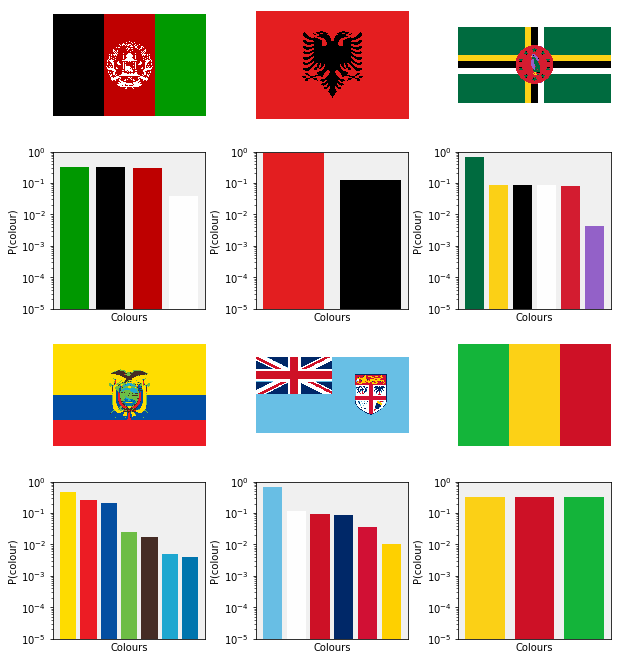

In [11]:
# TO SKIP -- plot setup

groups = []
for image in ref_images:
    clnr = ImageScalerCleaner()
    cleaned = clnr.clean(image)
    groups.append((cleaned, clnr.histo, ""))
    
plot_flag_histo_label_groups(groups)

## Comparison

Two of the cleaning methods has hyparameters:
* `ImageVornoiCluster`: maximum number of clusters (15)
* `ImageScalerCleaner`: the scale factor (3) and tolerance of the colour ratio (0.1 * scale factor square)

A cross validation might be timely to establish the optimal values of these parameters. It would be of modest yield and delight, for these parameters have already been set after considerable amount of experimentation. What we do instead it is to compare how well these methods recover the original flags. We do know there is about 2% satellite colours in each flag. Whichever method approximates of goes beyond the most of this limit will be chosen to clean the flags.

The measure of goodness, $f(\mathbf{A}, \mathbf{A}_{clean})$ is taken to be the normalised pixelwise overlap between the orginal and the cleaned images.

$$
f(\mathbf{A}, \mathbf{A}_{clean}) = \frac{\| \mathbf{A} - \mathbf{A}_{clean} \|_{2}}{h_{A} \cdot w_{A} \cdot 256}
$$

The distribution of scores and the boxplots are generated over all flags. 

In [12]:
# TO SKIP -- boring

def calculate_overlap(X, X_clean):
    """
    Calculates the pixelwise overlap between two images.
    Parameters:
        X (np.ndarray[width, heigth, {3,4}]) : R,G,B[,A] image
        X_clean (np.ndarray[width, heigth, 3]) : clean R,G,B image
    Return:
        overlap (float) : pixelwise normalised overlap. 1: perfect. 0: time to think about my prospects.
    """
    
    X_diff = (X[:,:,:3] - X_clean)
    overlap = np.mean(np.sqrt(np.sum(X_diff * X_diff, axis = -1)))
    overlap = 1 - overlap / 256
    
    return overlap

In [13]:
# TO SKIP -- boring

path_to_dir = r'C:\Users\hornu\OneDrive\Documents\repos\flags\data\clean-data\images'
all_paths = [os.path.join(path_to_dir, x) for x in os.listdir(path_to_dir) if x.endswith(".png")]
images = [imread(x) for x in all_paths]

In [14]:
# TO SKIP -- boring

# Voronoi cleaner
voronoi_scores = [calculate_overlap(x, ImageVoronoiCleaner().clean(x)) for x in images]
voronoi_scores = np.array(voronoi_scores)

# Felzenszwalb cleaner
felzen_scores = [calculate_overlap(x, ImageFelzenCleaner(min_size = 'diag').clean(x)) for x in images]
felzen_scores = np.array(felzen_scores)

# scaler cleaner
scaler_scores = [calculate_overlap(x, ImageScalerCleaner().clean(x)) for x in images]
scaler_scores = np.array(scaler_scores)

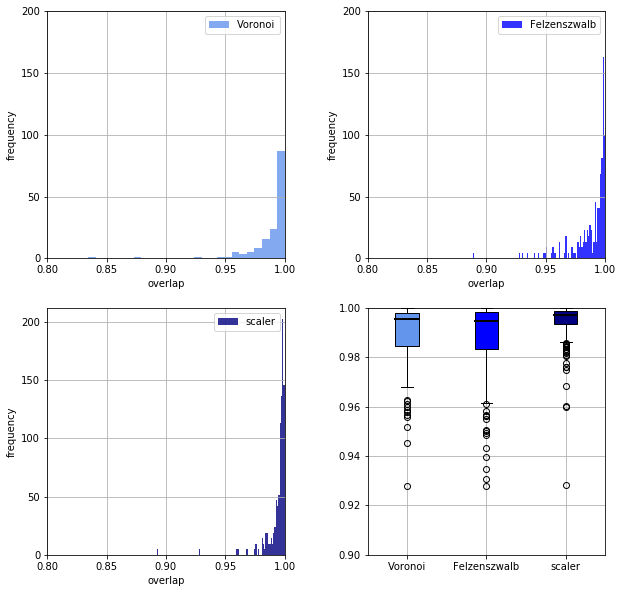

In [15]:
# TO SKIP -- setup

scores = voronoi_scores, felzen_scores, scaler_scores
labels = 'Voronoi', 'Felzenszwalb', 'scaler'
colors = 'cornflowerblue', 'blue', 'navy'

fig, axes = plt.subplots(2,2, gridspec_kw = {'wspace' : 0.35})#, sharey = True)
fig.set_size_inches(10, 10)

for ax, score, color, label in zip(axes.flat, scores, colors, labels):
    
    _ = ax.hist(score, bins = 100, density = True, color = color, alpha = 0.8, label = label)
    
    ax.grid(True)
    ax.set_xlim((0.8, 1))
    ax.set_xlabel('overlap')
    ax.set_ylabel('frequency')
    
    ax.legend()
    ax.set_yticks([0, 50, 100, 150, 200])
 

box_plot = axes[1,1].boxplot(scores, labels = labels, patch_artist = True,
                             medianprops = dict(linewidth = 2, color = 'black') )

for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
        
axes[1,1].grid(True)
axes[1,1].set_ylim((0.9, 1.0))
plt.show()

Surprisingly enough, the simplest least theoretically funded method, `ImageScalerCleaner` performs the best. It relies on a very simple and justfiable assumption, namely the propensity of satellite colours is proportional to the dimensions of the image, whilst the propensity of the main colours is proportional to the area of the image.

## Summary

We have successfully coined and implemented a method that rectifies the effect of finite resolution on coloured images.